In [428]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from itertools import groupby



import seaborn as sns
import copy
from sklearn.linear_model import LassoCV
from scipy.stats import spearmanr
from scipy.stats import ttest_1samp

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer




import warnings
warnings.filterwarnings("ignore")

## Data transformation & Daily / hourly split functions

In [426]:
def brut_to_hourly(exch,asset):
    """
    This function takes as an input an exchange name and an asset name.
    It extracts all the available data corresponding to the asset in that exchange
    Resamples it by hour, then proceeds to create various CSV files for each hour of the data.
    """
    files_names = []
    for day in ['02-28','03-01','03-02','03-03','03-04','03-05']:
        path = 'C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/tardis_raw_1/' + str(exch) + '/'+str(exch)+'_book_snapshot_5_2022-'+ day + '_' +str(exchanges[exch][asset])+'USDT'+'.csv.gz'
        original = pd.read_csv(path,parse_dates=True)
        original['date'] = (original['timestamp']/10**6).apply(datetime.fromtimestamp)
        original.set_index('date', inplace=True)
        groups = original.resample('1H')
        for name, group in groups:
            filename = f'data_{name.strftime("%Y%m%d_%H")}.csv'
            files_names.append(filename)
            group.to_csv(f'C:\\Users\\elaar\\OneDrive\\Bureau\\COURS\\Dauphine Master 203\\M2\\2nd semester\\Electronic markets\\tardis_raw_1\\binance\\hourly_data\\{asset}\\{filename}')
    return files_names

def brut_to_onedf(exch,asset):
    """
    This function takes as an input an exchange name and an asset name.
    It extracts all the available data corresponding to the asset in that exchange.
    Then concatenates everything and returns one single dataframe.
    """
    files = []
    for day in ['02-28','03-01','03-02','03-03','03-04','03-05']:
        path = 'C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/tardis_raw_1/' + str(exch) + '/'+str(exch)+'_book_snapshot_5_2022-'+ day + '_' +str(exchanges[exch][asset])+'USDT'+'.csv.gz'
        original = pd.read_csv(path,parse_dates=True)
        original['date'] = (original['timestamp']/10**6).apply(datetime.fromtimestamp)
        original.set_index('date', inplace=True)
        files.append(original)
    
    return pd.concat(files)

def brut_to_dict(exch,asset):
    """
    This function takes as an input an exchange name and an asset name.
    It extracts all the available data corresponding to the asset in that exchange.
    Resamples it by day, then implements it into a dictionary.   
    """
    files = {}
    for day in ['02-28','03-01','03-02','03-03','03-04','03-05']:
        path = 'C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/tardis_raw_1/' + str(exch) + '/'+str(exch)+'_book_snapshot_5_2022-'+ day + '_' +str(exchanges[exch][asset])+'USDT'+'.csv.gz'
        original = pd.read_csv(path,parse_dates=True)
        original['date'] = (original['timestamp']/10**6).apply(datetime.fromtimestamp)
        original.set_index('date', inplace=True)
        files[day] = original
    
    return files


In [ ]:
################################ extracts the filenames present in a specified folder path ############################################
folder_path = 'C:\\Users\\elaar\\OneDrive\\Bureau\\COURS\\Dauphine Master 203\\M2\\2nd semester\\Electronic markets\\tardis_raw_1\\binance\\hourly_data\\ethereum'
files_names = os.listdir(folder_path)


exch = 'binance'
asset = 'ethereum'

files_names = brut_to_hourly(exch,asset)

## Main Functions: features, strategies...

In [555]:
def feature_creation(df):
    """
    This function takes as an input a DataFrame and returns the same DataFrame but with some added features
    """
    
    xrp_vol_bid = df[['bids[4].amount',
                    'bids[3].amount',
                    'bids[2].amount',
                    'bids[1].amount',
                    'bids[0].amount']]
    
    xrp_vol_ask = df[['asks[0].amount',
                    'asks[1].amount',
                    'asks[2].amount',
                    'asks[3].amount',
                    'asks[4].amount']]

    xrp_volumes = df[['bids[4].amount',
                    'bids[3].amount',
                    'bids[2].amount',
                    'bids[1].amount',
                    'bids[0].amount',
                    'asks[0].amount',
                    'asks[1].amount',
                    'asks[2].amount',
                    'asks[3].amount',
                    'asks[4].amount']]

    xrp_prices = df[['bids[4].price',
                    'bids[3].price',
                    'bids[2].price',
                    'bids[1].price',
                    'bids[0].price',
                    'asks[0].price',
                    'asks[1].price',
                    'asks[2].price',
                    'asks[3].price',
                    'asks[4].price']]

    df['total_ask_vol'] = xrp_vol_ask.sum(axis=1)
    df['total_bid_vol'] = xrp_vol_bid.sum(axis=1)
    df['mean_ask_vol'] = xrp_vol_ask.mean(axis=1)
    df['mean_bid_vol'] = xrp_vol_bid.mean(axis=1)
    df['median_ask_vol'] = xrp_vol_ask.median(axis=1)
    df['median_bid_vol'] = xrp_vol_bid.median(axis=1)
    df['bid_ask_spread'] = xrp_prices['asks[0].price'] - xrp_prices['bids[0].price'] 
    
    for i in range(5):
        df[f'ratio_ask_{i}_vol_vs_mean'] = xrp_volumes[f'asks[{i}].amount'] / df['mean_ask_vol']
        df[f'ratio_bid_{i}_vol_vs_mean'] = xrp_volumes[f'bids[{i}].amount'] / df['mean_bid_vol']
        df[f'ratio_ask_{i}_vol_vs_median'] = xrp_volumes[f'asks[{i}].amount'] / df['median_ask_vol']
        df[f'ratio_bid_{i}_vol_vs_median'] = xrp_volumes[f'bids[{i}].amount'] / df['median_bid_vol']
    
    for i in range(1,7):
        df[f'total_ask_vol_lagged_{i}'] = xrp_vol_ask.sum(axis=1).shift(i*10)
        df[f'total_bid_vol_lagged_{i}'] = xrp_vol_bid.sum(axis=1).shift(i*10)


    df['bid_ask_vol_ratio'] = (df.total_bid_vol/df.total_ask_vol) - 1
    df['mid']     = xrp_prices.mean(axis=1)
    df['mid_perf']      = df.mid.pct_change()
    df.mid_perf.fillna(df.mid_perf.mean(),inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    return df

def max_to_short(df_data,max_value_range=1500,eps = 0.01,time_period=1000,capital=1,show=False):
    """
    Takes in input a dataframe containing the data. User can change the input parameters.
        - max_value_range: represents the number of observations up to the current observation that will be considered for the maximum
        - time_period: represents how long a position will stay open for.
        - capital: the capital that the position starts with
        - show: a boolean: if True will show the various PnL variations seperatly (in different graphs).
                           if False will only show one graph at the end containing all the PnL curves.
                           
    The function takes in the data, and checks for a specific condition: are we close to the [t,t-max_value_range] maximum mid-price ?
    As long as the condition is met, the function will open a short position at each observation lasting for a period = time_period.
    We then append the returns taking into account the set starting capital, plot the evolution of the PnL and return the PnL feature.   
    """
    
    #start by deepcopying the dataframe to avoid affecting the original data
    df = copy.deepcopy(df_data)
    
    #initializing variables
    df['strat_perf'] = np.nan
    pnl = []

    for j in range(len(df)):
        #iterates through all observations
        if df.mid.iloc[max(j-max_value_range,0):j].max()*(1-eps) < df.mid.iloc[j] <= df.mid.iloc[max(j-max_value_range,0):j].max():
            #next_pos represents the exit point of the position. Becomes smaller when we  get closer from the final values (inal_value_index - current index < time_period).
            next_pos = min(j+time_period,len(df)-1)
            df['strat_perf'].iloc[j] = ((df['bids[0].price'].iloc[next_pos] / df['asks[0].price'].iloc[j]) - 1)*capital
    
    #drop nan values and get rid of group by values
    input_list = df.strat_perf.dropna().to_list()
    for key, _ in groupby(input_list):
        pnl.append(key)
    plt.plot(pd.Series(pnl      ,index=np.arange(0,len(pnl    ))).iloc[:-int(time_period/100)])
    if show:
        plt.show()
    
    print('mean PnL : ', np.mean(pnl))
    return pnl

def max_to_long(df_data,eps = 0.01,max_value_range=1500,time_period=1000,capital=1,show=False):
    """
    Takes in input a dataframe containing the data. User can change the input parameters.
        - max_value_range: represents the number of observations up to the current observation that will be considered for the maximum
        - time_period: represents how long a position will stay open for.
        - capital: the capital that the position starts with
        - show: a boolean: if True will show the various PnL variations seperatly (in different graphs).
                           if False will only show one graph at the end containing all the PnL curves.
                           
    The function takes in the data, and checks for a specific condition: are we close to the [t,t-max_value_range] maximum mid-price ?
    As long as the condition is met, the function will open a long position at each observation lasting for a period = time_period.
    We then append the returns taking into account the set starting capital, plot the evolution of the PnL and return the PnL feature.   
    """
    
    #start by deepcopying the dataframe to avoid affecting the original data
    df = copy.deepcopy(df_data)
    
    #initializing variables
    df['strat_perf'] = np.nan
    pnl = []

    for j in range(len(df)):
        #iterates through all observations
        if df.mid.iloc[max(j-max_value_range,0):j].max()*(1-eps) < df.mid.iloc[j] <= df.mid.iloc[max(j-max_value_range,0):j].max():
            #next_pos represents the exit point of the position. Becomes smaller when we  get closer from the final values (inal_value_index - current index < time_period).
            next_pos = min(j+time_period,len(df)-1)
            df['strat_perf'].iloc[j] = ((df['asks[0].price'].iloc[next_pos] / df['bids[0].price'].iloc[j]) - 1)*capital
    
    #drop nan values and get rid of group by values
    input_list = df.strat_perf.dropna().to_list()
    for key, _ in groupby(input_list):
        pnl.append(key)
        
    
    plt.plot(pd.Series(pnl      ,index=np.arange(0,len(pnl    ))).iloc[:-int(time_period/100)])
    if show:
        plt.show()
    
    print('mean PnL : ', np.mean(pnl))
    return pnl



def bid_ask_vol_diff(df,time_period=1000,eps = 0.1,capital=1,show=False):
    
    df['strat_perf'] = np.nan
    avg = (df.total_ask_vol - df.total_bid_vol).iloc[:int(len(df)/10)].mean()
    upper_b = avg + (df.total_ask_vol - df.total_bid_vol).iloc[:int(len(df)/10)].median() 
    lower_b = avg - (df.total_ask_vol - df.total_bid_vol).iloc[:int(len(df)/10)].median()


    sell = False
    buy = False
    perf = []
    next_pos = 0

    for j in range(int(len(df)/10),len(df)):
        if (df.total_bid_vol - df.total_ask_vol).iloc[j] > upper_b and sell == False and upper_b > 0 :
            sell = True
            idx_price = df[f'asks[0].price'].iloc[j]
            idx = j
            next_pos = min(len(df)-1,idx+time_period)
            
            if np.isnan((df['bids[0].price'].iloc[next_pos] / idx_price) -1):
                perf.append(0)
            else:
                capital+=((df['bids[0].price'].iloc[next_pos] / idx_price) -1) * capital
                perf.append(((df['bids[0].price'].iloc[next_pos] / idx_price) -1) * capital)

        elif (df.total_bid_vol - df.total_ask_vol).iloc[j] < lower_b and buy == False and lower_b < 0:
            buy = True
            idx_price = df[f'bids[0].price'].iloc[j]
            idx = j
            next_pos = min(len(df)-1,idx+time_period)
            
            if np.isnan((df['asks[0].price'].iloc[next_pos] / idx_price) -1):
                perf.append(0)
            else:
                capital+=((df['asks[0].price'].iloc[next_pos] / idx_price) -1) * capital
                perf.append(((df['asks[0].price'].iloc[next_pos] / idx_price) -1) * capital)
            
        if j > next_pos:
                sell = False
                buy = False

    return perf



## Price-based Strategies

mean PnL :  1.28150966270496e-05
The returns' mean is statistically different from zero.


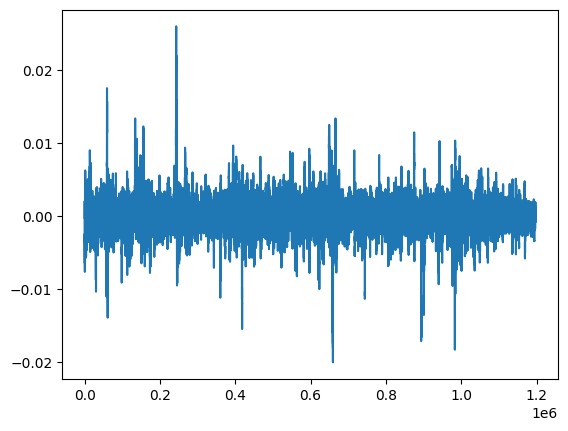

In [545]:
df      = brut_to_onedf(exch,asset)
df      = feature_creation(df)

max_short_eth_all = max_to_short(df,max_value_range=1500,eps = 0.01,time_period=1000,capital=1,show=False)


t_statistic, p_value = ttest_1samp(max_short_eth_all, 0)
# Compare the p-value to a significance level of 5%
if p_value < 0.05:
    print("The returns are statistically different from zero.")
else:
    print("The returns are not statistically different from zero.")

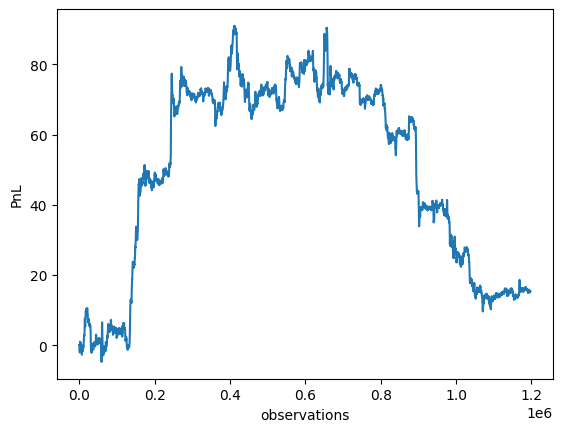

In [546]:
plt.plot(np.cumsum(max_short_eth_all),label='PnL')
plt.xlabel('observations')
plt.ylabel('PnL')
plt.show()

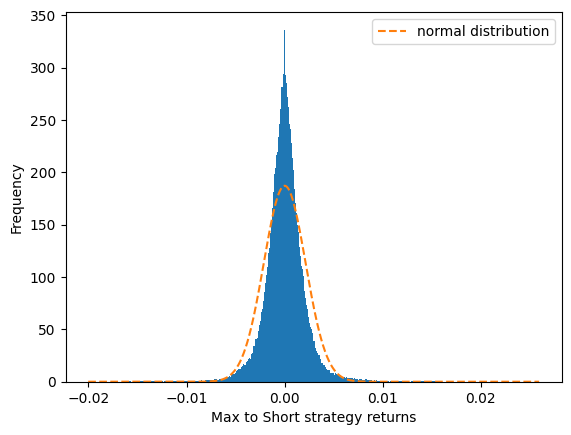

the J-B stat on the max to short strategy returns:  Jarque_beraResult(statistic=4913354.250716512, pvalue=0.0)
the skewness test on the max to short strategy returns:  0.15976573936806582


In [547]:
returns = max_short_eth_all
n, bins, patches = plt.hist(returns, bins=2000, density=True)

# Fit a normal distribution to the returns
mu, std = np.mean(returns), np.std(returns)
y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
plt.plot(bins, y, '--',label='normal distribution')

# Add labels and title to the plot
plt.xlabel('Max to Short strategy returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('the J-B stat on the max to short strategy returns: '      ,jarque_bera(max_short_eth_all))
print('the skewness test on the max to short strategy returns: ' ,skew(max_short_eth_all))

mean PnL :  3.256435958661593e-05
The returns' mean is statistically different from zero.


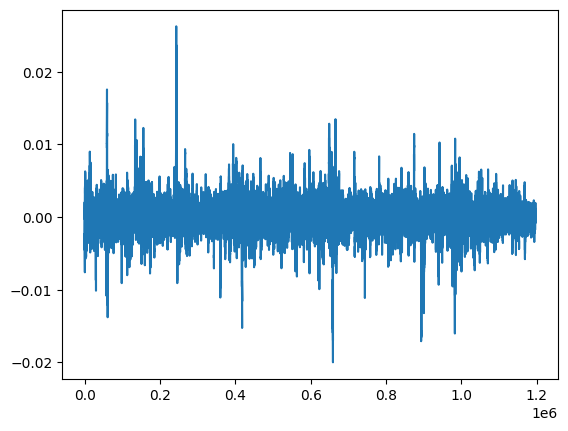

In [548]:
df      = brut_to_onedf(exch,asset)
df      = feature_creation(df)

max_long_eth_all = max_to_long(df,max_value_range=1500,eps = 0.01,time_period=1000,capital=1,show=False)



t_statistic, p_value = ttest_1samp(max_long_eth_all, 0)
# Compare the p-value to a significance level of 5%
if p_value < 0.05:
    print("The returns are statistically different from zero.")
else:
    print("The returns are not statistically different from zero.")

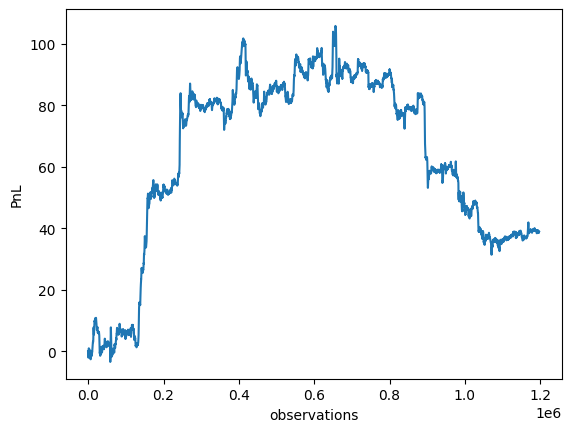

In [549]:
plt.plot(np.cumsum(max_long_eth_all),label='PnL')
plt.xlabel('observations')
plt.ylabel('PnL')
plt.show()

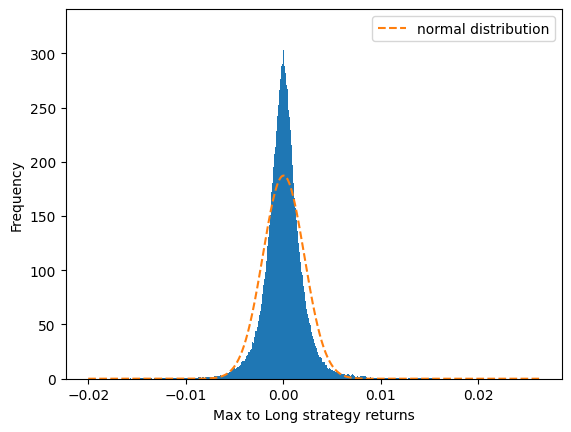

the J-B stat on the max to Long strategy returns:  Jarque_beraResult(statistic=4943306.876638351, pvalue=0.0)
the skewness test on the max to Long strategy returns:  0.18686112283819425


In [550]:
returns = max_long_eth_all
n, bins, patches = plt.hist(returns, bins=2000, density=True)

# Fit a normal distribution to the returns
mu, std = np.mean(returns), np.std(returns)
y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
plt.plot(bins, y, '--',label='normal distribution')

# Add labels and title to the plot
plt.xlabel('Max to Long strategy returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('the J-B stat on the max to Long strategy returns: '      ,jarque_bera(max_long_eth_all))
print('the skewness test on the max to Long strategy returns: ' ,skew(max_long_eth_all))

## Sentiment-based Strategy

## Tweets signal

In [ ]:
#referance dictionnary, used for data loading 
exchanges = {
    'binance':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USDT',
        },
    'coinbase':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            #'ripple':'xrp',
            'dollar':'USD',
        }, 
    'ftx':
        {
            'bitcoin':'BTC',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        }, 
    'bitmex':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    'kraken':
        {
            'bitcoin':'XBT',
            'ethereum':'ETH',
            'litecoin':'LTC',
            'solana':'SOL',
            'ripple':'XRP',
            'dollar':'USD',
        },
    }

In [ ]:
# initializing variables
days = 6
date = datetime(2022, 2, 28)
dates = [(date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(days)]

exch = 'binance'
asset = 'ethereum'

# time frequency
fq = '1min'

# concatenate all date over the 6 day period into single dataframe but resampled by frequency
ob_fq = pd.DataFrame()
for date_str in dates:
    try:
        path = 'C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/tardis_raw_1/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+exchanges[exch]['dollar']+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
    except Exception as e:
        print(e)
        path = 'C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/tardis_raw_1/'+exch+'/'+exch+'_book_snapshot_5_'+date_str+'_'+exchanges[exch][asset]+'USDT'+'.csv.gz'
        ob = pd.read_csv(path, compression='gzip')
        pass
    ob.sort_values(by='timestamp')
    ob['date_time'] = pd.to_datetime(ob['timestamp'], unit='us')
    # Resample the data to seperate it into smaller DataFrames corresponding to 1min data.
    # Then take only the first row representative of the 1min data
    ob_fq=ob_fq.append(ob.resample(fq, on='date_time', label='right').first())

ob_fq['datetime']=ob_fq.index

# compute returns
ob_fq['mid_price'] = (ob_fq['asks[0].price'] + ob_fq['bids[0].price'])/2
ob_fq['returns'] = ob_fq['mid_price'].pct_change()
ob_fq['binary_returns'] = ob_fq['returns'].apply(lambda x: 1 if x>0 else 0)

#load the tweets file
tweets = pd.read_csv('C:/Users/elaar/OneDrive/Bureau/COURS/Dauphine Master 203/M2/2nd semester/Electronic markets/electronic_markets_matthieu_1/tweets_stemmed_hashtags_no_stopwords.csv')
tweets['datetime'] = pd.to_datetime(tweets.timestamp, infer_datetime_format=True)
tweets = tweets.sort_values(by='datetime')

tweets_fq = []
for i in range(ob_fq.shape[0]-1):
    tweets_one_period = []
    #get all tweets between 2 timestamps
    mask = (tweets['datetime'] > ob_fq['datetime'].iloc[i]) & (tweets['datetime'] <= ob_fq['datetime'].iloc[i+1])
    tweets_filtered = tweets[mask]
    if len(tweets_filtered)>0:
        try:
            dt = ob_fq['datetime'].iloc[i+2]
        except:
            dt = ob_fq['datetime'].iloc[i+1]
        tw = " ".join([tweet for tweet in tweets_filtered['tweet_stemmer_hashtags_no_stopwords']])
        tweets_fq.append([dt, tw])

tweets_fq = pd.DataFrame(tweets_fq, columns=['datetime', 'tweets'])
tweets_fq.reset_index(drop = True, inplace = True)
ob_fq.reset_index(drop = True, inplace = True)
full_data = pd.merge(tweets_fq, ob_fq, on='datetime')

# train test split model
df_train, df_test, y_train, y_test = train_test_split(full_data.drop(['binary_returns'], axis=1), full_data["binary_returns"], random_state=203, test_size=0.30)
n_train = y_train.shape[0]
n_test = y_test.shape[0]

# vectorizer: computes the number of times a words was repeated within the tweets
# very important step, will give us later on the relationship between the tweets and the market sentiment
vectorizer = CountVectorizer()
vect = vectorizer.fit(df_train["tweets"])
x_train = vect.transform(df_train["tweets"])

# Fit a logistic regression on the train dataset
clf = LogisticRegression(penalty="none")
model = clf.fit(x_train, y_train)

# Make predictions on train dataset + validation set (K-fold)
pred_train = model.predict(x_train)
pred_val = cross_val_predict(clf, x_train, y_train, cv=15)

#resample the tweet predictions by day and take only the average
tweet_signal = pd.Series(pred_val,index=df_train.datetime).sort_index().resample('1D').mean()

In [ ]:
tweet_signal

datetime
2022-02-28    0.419355
2022-03-01    0.490909
2022-03-02    0.521739
2022-03-03    0.409836
2022-03-04    0.410714
2022-03-05    0.522388
2022-03-06    1.000000
Freq: D, dtype: float64

In [ ]:
######################################### Simulation using the tweet signal ######################################### 
df = brut_to_onedf(exch,asset)
df['date'] = (df['timestamp']/10**6).apply(datetime.fromtimestamp)
df      = feature_creation(df)

#separating per day
dfs_by_day = brut_to_dict(exch,asset)

final_pnl_tweet_signal = []
j = 0
for date in list(dfs_by_day.keys()):
        """
        Goes through all the days, checks the tweet signal for the market sentiment
        Then decides to use the max to short or the max to long functions
        """
        
        print(f'_________________________________day_{j}_________________________________')
        
        daily_pnl = []
        if tweet_signal.values[j] > 0.5:
                try:
                        d       = dfs_by_day[date]
                        l       = max_downward_list(d)
                except Exception:
                        pass
                daily_pnl += l
        else:
                try:
                        d       = dfs_by_day[date]
                        l       = max_upward_list(d)       
                except Exception:
                        pass
                daily_pnl += l
        
        final_pnl_tweet_signal += daily_pnl
        j+=1
print('PnL over the period -> ', np.sum(final_pnl_tweet_signal))

pd.Series(final_pnl_tweet_signal,index=np.arange(len(final_pnl_tweet_signal))).cumsum().plot()
plt.show()
n, bins, patches = plt.hist(final_pnl_tweet_signal, bins=2000, density=True)
plt.show()


In [ ]:
plt.plot(np.cumsum(final_pnl_tweet_signal),label='PnL')
plt.xlabel('observations')
plt.ylabel('PnL')
plt.show()

In [ ]:
returns = final_pnl_tweet_signal
n, bins, patches = plt.hist(returns, bins=2000, density=True)

# Fit a normal distribution to the returns
mu, std = np.mean(returns), np.std(returns)
y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
plt.plot(bins, y, '--',label='normal distribution')

# Add labels and title to the plot
plt.xlabel('Tweet signal strategy returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('the J-B stat on the Tweet signal strategy returns: '      ,jarque_bera(final_pnl_tweet_signal))
print('the skewness test on the Tweet signal strategy returns: ' ,skew(final_pnl_tweet_signal))

In [ ]:
t_statistic, p_value = ttest_1samp(final_pnl_tweet_signal, 0)

# Compare the p-value to a significance level of 5%
if p_value < 0.05:
    print("The value is statistically different from zero.")
else:
    print("The value is not statistically different from zero.")

## OrderBook based strategy

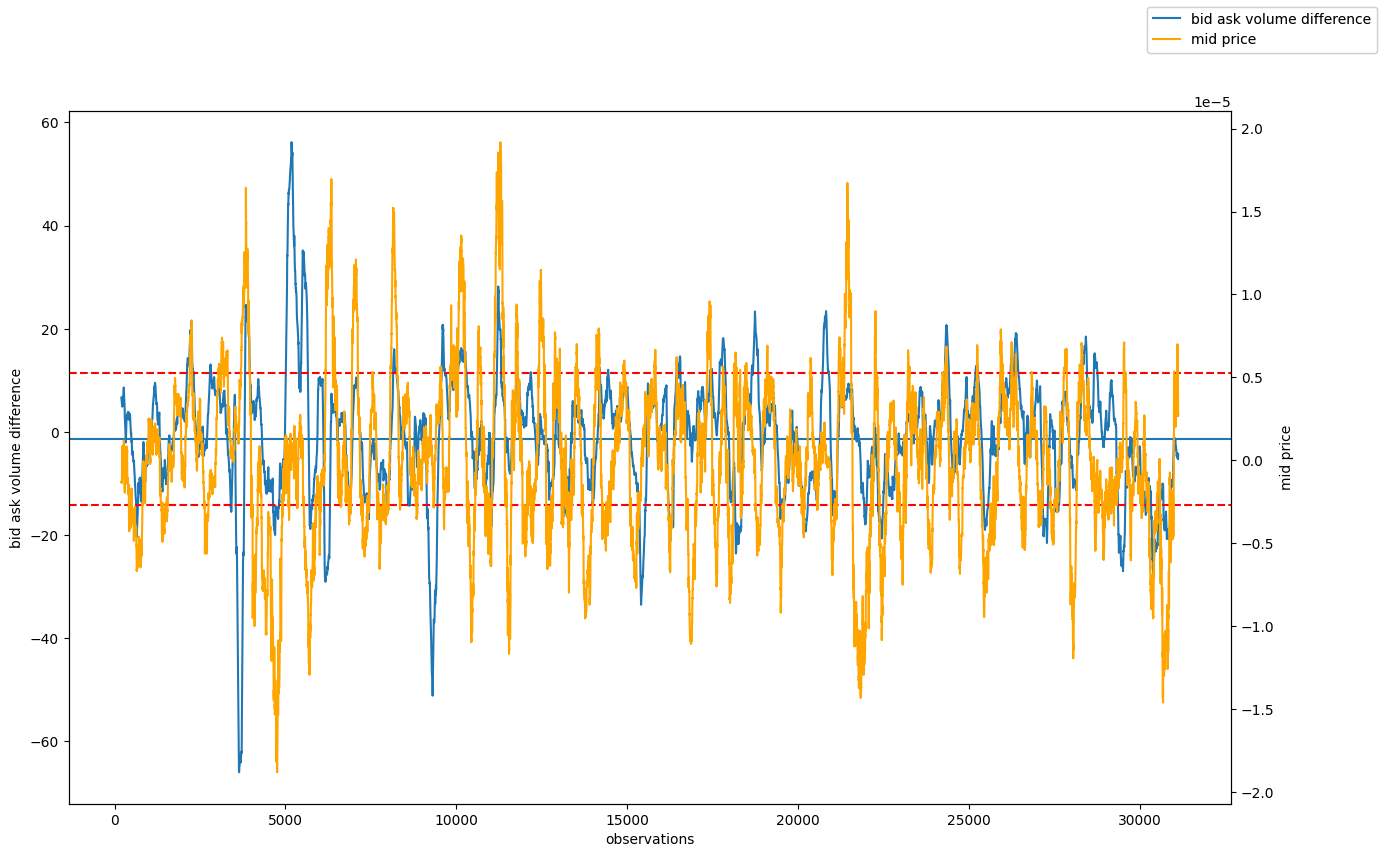

In [417]:
# load the data
df      = pd.read_csv(f'C:\\Users\\elaar\\OneDrive\\Bureau\\COURS\\Dauphine Master 203\\M2\\2nd semester\\Electronic markets\\tardis_raw_1\\binance\\hourly_data\\ethereum\\{files_names[12]}')
df      = feature_creation(df)

fig, ax1 = plt.subplots(figsize = (15,9))

ax2 = ax1.twinx()
ax2.plot(df.mid_perf.rolling(window=200).mean(),'orange',label='mid price')
ax1.plot(df.total_bid_vol.rolling(window=200).mean()- df.total_ask_vol.rolling(window=200).mean() ,label='bid ask volume difference')

ax1.axhline(((df.total_ask_vol - df.total_bid_vol).iloc[:3000]).mean())
ax1.axhline(((df.total_ask_vol - df.total_bid_vol).iloc[:3000]).mean() + np.abs((df.total_ask_vol - df.total_bid_vol).iloc[:3000]).median()  , color='r', linestyle='--')
ax1.axhline(((df.total_ask_vol - df.total_bid_vol).iloc[:3000]).mean() - np.abs((df.total_ask_vol - df.total_bid_vol).iloc[:3000]).median() , color='r', linestyle='--')

ax1.set_xlabel('observations')
ax1.set_ylabel('bid ask volume difference')
ax2.set_ylabel('mid price')

# Create a shared legend for both axes
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
shared_legend = fig.legend(handles, labels, loc='upper right')

# Set the legend for each axis to the shared legend
ax1.add_artist(shared_legend)


plt.show()


_________________________________day_0_________________________________
PnL of the hour n°0 ->  -0.007148161919811504
PnL of the hour n°1 ->  0.019004857025538908
PnL of the hour n°2 ->  0.0
PnL of the hour n°3 ->  -0.0030042854447480368
PnL of the hour n°4 ->  -0.003053191709949278
PnL of the hour n°5 ->  0.0
PnL of the hour n°6 ->  -0.011710324870842663
PnL of the hour n°7 ->  0.011634206199540312
PnL of the hour n°8 ->  -0.01143160603633351
PnL of the hour n°9 ->  0.0
PnL of the hour n°10 ->  0.00993418229246432
PnL of the hour n°11 ->  0.005604073297723559
PnL of the hour n°12 ->  0.0
PnL of the hour n°13 ->  0.0
PnL of the hour n°14 ->  0.08829371311581467
PnL of the hour n°15 ->  0.0
PnL of the hour n°16 ->  -0.011066989423985811
PnL of the hour n°17 ->  0.023457721615225934
PnL of the hour n°18 ->  -0.006416979678885285
PnL of the hour n°19 ->  0.017297550184374948
PnL of the hour n°20 ->  0.0
PnL of the hour n°21 ->  -0.0029963171996712354
PnL of the hour n°22 ->  0.04136604598

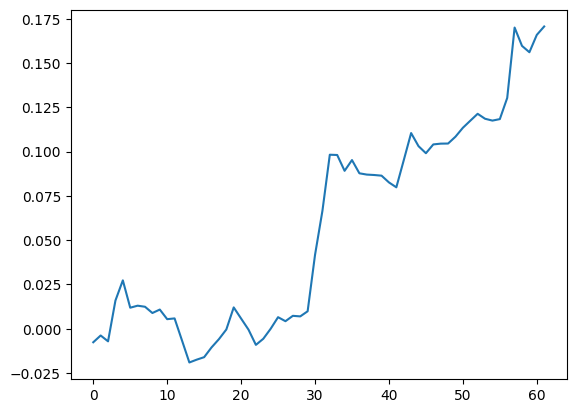

_________________________________day_1_________________________________
PnL of the hour n°0 ->  0.001390584292420843
PnL of the hour n°1 ->  -0.01493737185562984
PnL of the hour n°2 ->  0.002317150439387115
PnL of the hour n°3 ->  0.0029315059675966743
PnL of the hour n°4 ->  0.008750666014570103
PnL of the hour n°5 ->  -0.01986634423710449
PnL of the hour n°6 ->  0.008450787370696905
PnL of the hour n°7 ->  0.0014196504802428383
PnL of the hour n°8 ->  -0.001197644854731316
PnL of the hour n°9 ->  -0.011846508581743706
PnL of the hour n°10 ->  0.015319945355745743
PnL of the hour n°11 ->  -0.0059074372177365395
PnL of the hour n°12 ->  0.03645320685945441
PnL of the hour n°13 ->  0.029655944971099493
PnL of the hour n°14 ->  0.0
PnL of the hour n°15 ->  0.0
PnL of the hour n°16 ->  -0.017543688732785723
PnL of the hour n°17 ->  0.0
PnL of the hour n°18 ->  0.014303404259728774
PnL of the hour n°19 ->  -0.0038493735207887477
PnL of the hour n°20 ->  0.018042472546241903
PnL of the hour

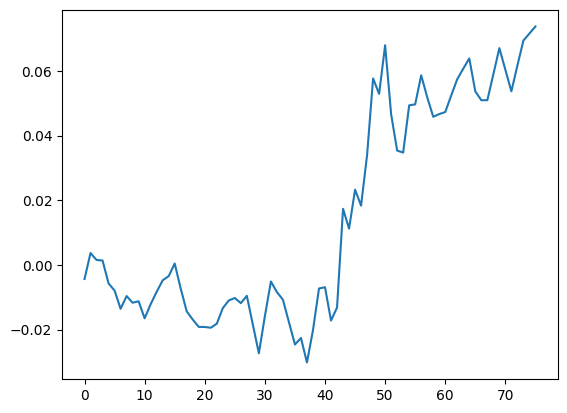

_________________________________day_2_________________________________
PnL of the hour n°0 ->  -0.019492752944684846
PnL of the hour n°1 ->  0.0
PnL of the hour n°2 ->  0.007998831102944526
PnL of the hour n°3 ->  0.04061816838663204
PnL of the hour n°4 ->  -0.018073576734820608
PnL of the hour n°5 ->  0.0
PnL of the hour n°6 ->  -0.028099938930867277
PnL of the hour n°7 ->  0.0020429190413032696
PnL of the hour n°8 ->  0.011553038260711105
PnL of the hour n°9 ->  0.0
PnL of the hour n°10 ->  0.012793716253528707
PnL of the hour n°11 ->  0.004461934271457593
PnL of the hour n°12 ->  -0.010586391296823443
PnL of the hour n°13 ->  -0.022669885887154073
PnL of the hour n°14 ->  0.030828862058070672
PnL of the hour n°15 ->  -0.03482586933137573
PnL of the hour n°16 ->  0.0040912178248295504
PnL of the hour n°17 ->  -0.011560752371615987
PnL of the hour n°18 ->  0.0
PnL of the hour n°19 ->  0.00026638240718998476
PnL of the hour n°20 ->  0.006413845175630628
PnL of the hour n°21 ->  0.0165

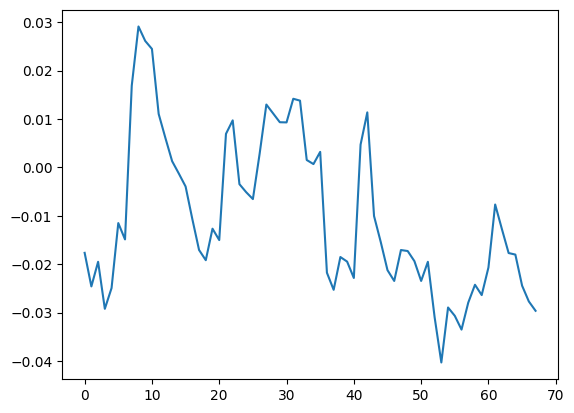

_________________________________day_3_________________________________
PnL of the hour n°0 ->  0.01454961739488337
PnL of the hour n°1 ->  -0.01921060226921142
PnL of the hour n°2 ->  0.0
PnL of the hour n°3 ->  -0.03507669142762456
PnL of the hour n°4 ->  -0.00044988730384817963
PnL of the hour n°5 ->  -0.0047890010119656075
PnL of the hour n°6 ->  0.009543384092535339
PnL of the hour n°7 ->  -0.004559509493736002
PnL of the hour n°8 ->  0.0025577307909213642
PnL of the hour n°9 ->  -0.008743617466372814
PnL of the hour n°10 ->  0.01724983421926374
PnL of the hour n°11 ->  0.008953329111786963
PnL of the hour n°12 ->  0.0
PnL of the hour n°13 ->  0.021015648550101775
PnL of the hour n°14 ->  -0.025699758832373312
PnL of the hour n°15 ->  -0.030759387907634432
PnL of the hour n°16 ->  0.0042332961701078645
PnL of the hour n°17 ->  0.0
PnL of the hour n°18 ->  -0.006322380317321662
PnL of the hour n°19 ->  0.0012235842431772411
PnL of the hour n°20 ->  -0.010021195136412116
PnL of the 

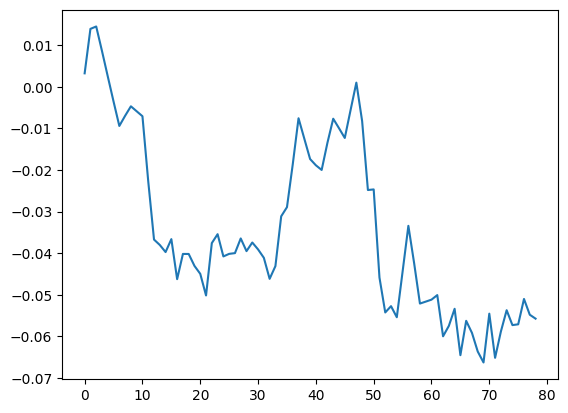

_________________________________day_4_________________________________
PnL of the hour n°0 ->  -0.10955776514086597
PnL of the hour n°1 ->  0.0
PnL of the hour n°2 ->  0.0016626754916383851
PnL of the hour n°3 ->  0.0035833348254434854
PnL of the hour n°4 ->  0.004006961133481882
PnL of the hour n°5 ->  -0.00043395486817741035
PnL of the hour n°6 ->  -0.008779228076407316
PnL of the hour n°7 ->  0.0
PnL of the hour n°8 ->  0.0042190368360452615
PnL of the hour n°9 ->  -0.022059450495488405
PnL of the hour n°10 ->  0.0
PnL of the hour n°11 ->  0.0
PnL of the hour n°12 ->  0.0
PnL of the hour n°13 ->  -0.0022271856931901785
PnL of the hour n°14 ->  -0.005991903412455762
PnL of the hour n°15 ->  -0.028031752572501734
PnL of the hour n°16 ->  0.0034301414921708256
PnL of the hour n°17 ->  0.005114333069580827
PnL of the hour n°18 ->  0.0
PnL of the hour n°19 ->  -0.026990806892678885
PnL of the hour n°20 ->  -0.005953328235073244
PnL of the hour n°21 ->  -0.006676291469811992
PnL of the h

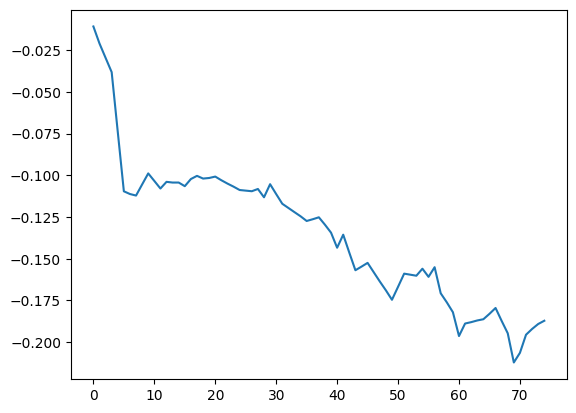

_________________________________day_5_________________________________
PnL of the hour n°0 ->  -0.013198522256426953
PnL of the hour n°1 ->  0.0
PnL of the hour n°2 ->  -0.001916832079472733
PnL of the hour n°3 ->  0.005630000029175783
PnL of the hour n°4 ->  -0.0029631236147337893
PnL of the hour n°5 ->  0.0
PnL of the hour n°6 ->  0.0030623294458920988
PnL of the hour n°7 ->  0.019785554092090422
PnL of the hour n°8 ->  0.010297629727129122
PnL of the hour n°9 ->  0.0
PnL of the hour n°10 ->  0.0015458606797178385
PnL of the hour n°11 ->  0.0002921367275659148
PnL of the hour n°12 ->  -0.00837401471520693
PnL of the hour n°13 ->  -0.0078887684172555
PnL of the hour n°14 ->  0.004180785421438403
PnL of the hour n°15 ->  -0.0008135516119719046
PnL of the hour n°16 ->  0.0
PnL of the hour n°17 ->  0.0020683030930110325
PnL of the hour n°18 ->  0.003937691669807292
PnL of the hour n°19 ->  -0.00012033590245892677
PnL of the hour n°20 ->  -0.0033847965891442154
PnL of the hour n°21 ->  -

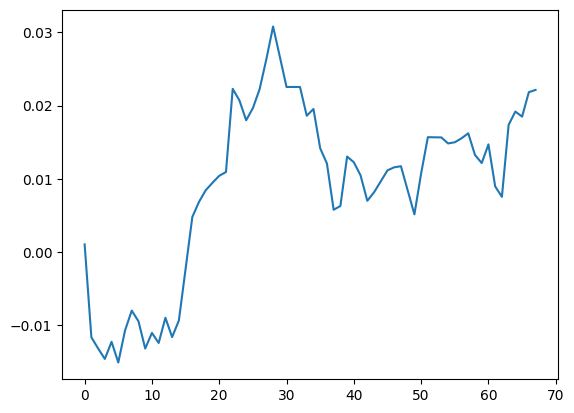

PnL over the period ->  -0.005895119544813449


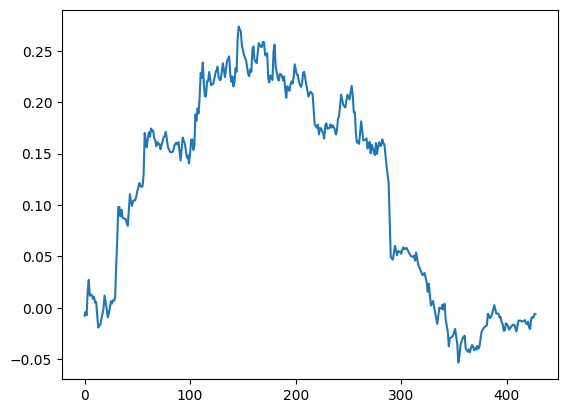

In [512]:
folder_name = 'ethereum'
path='C:\\Users\\elaar\\OneDrive\\Bureau\\COURS\\Dauphine Master 203\\M2\\2nd semester\\Electronic markets\\tardis_raw_1\\binance\\hourly_data\\' + str(folder_name)
final_pnl = []
pnl_bid_ask_ = []


for d in range(6):
    print(f'_________________________________day_{d}_________________________________')
    daily_pnl = []
    for i in range(int(len(files_names)/6)):
        df = pd.read_csv(f'{path}\\{files_names[d*24 + i]}')
        df['date'] = (df['timestamp']/10**6).apply(datetime.fromtimestamp)
        df      = feature_creation(df)
        perf = bid_ask_vol_diff(df,time_period=10000,eps = 0.1,capital=1.7,show=False)
        daily_pnl += perf
        print(f'PnL of the hour n°{i} -> ', np.sum(perf))
    print('PnL of the day -> ', np.sum(daily_pnl))
    pd.Series(daily_pnl,index=np.arange(len(daily_pnl))).cumsum().plot()
    plt.show()
    final_pnl += daily_pnl
print('PnL over the period -> ', np.sum(final_pnl))
pd.Series(final_pnl,index=np.arange(len(final_pnl))).cumsum().plot()
plt.show()


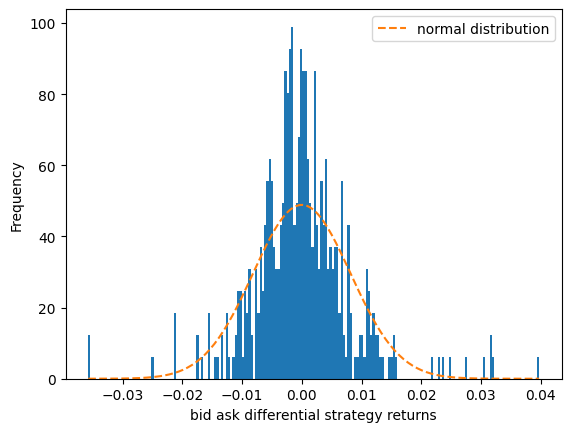

the J-B stat on the max to short strategy returns:  Jarque_beraResult(statistic=383.9747693740564, pvalue=0.0)
the skewness test on the max to short strategy returns:  0.48563453812848356


In [517]:
returns = final_pnl
n, bins, patches = plt.hist(returns, bins=200, density=True)

# Fit a normal distribution to the returns
mu, std = np.mean(returns), np.std(returns)
y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mu))**2))
plt.plot(bins, y, '--',label='normal distribution')

# Add labels and title to the plot
plt.xlabel('bid ask differential strategy returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('the J-B stat on the max to short strategy returns: '      ,jarque_bera(final_pnl))
print('the skewness test on the max to short strategy returns: ' ,skew(final_pnl))

In [531]:
t_statistic, p_value = ttest_1samp(final_pnl, 0)

# Compare the p-value to a significance level of 5%
if p_value < 0.05:
    print("The value is statistically different from zero.")
else:
    print("The value is not statistically different from zero.")

The value is not statistically different from zero.


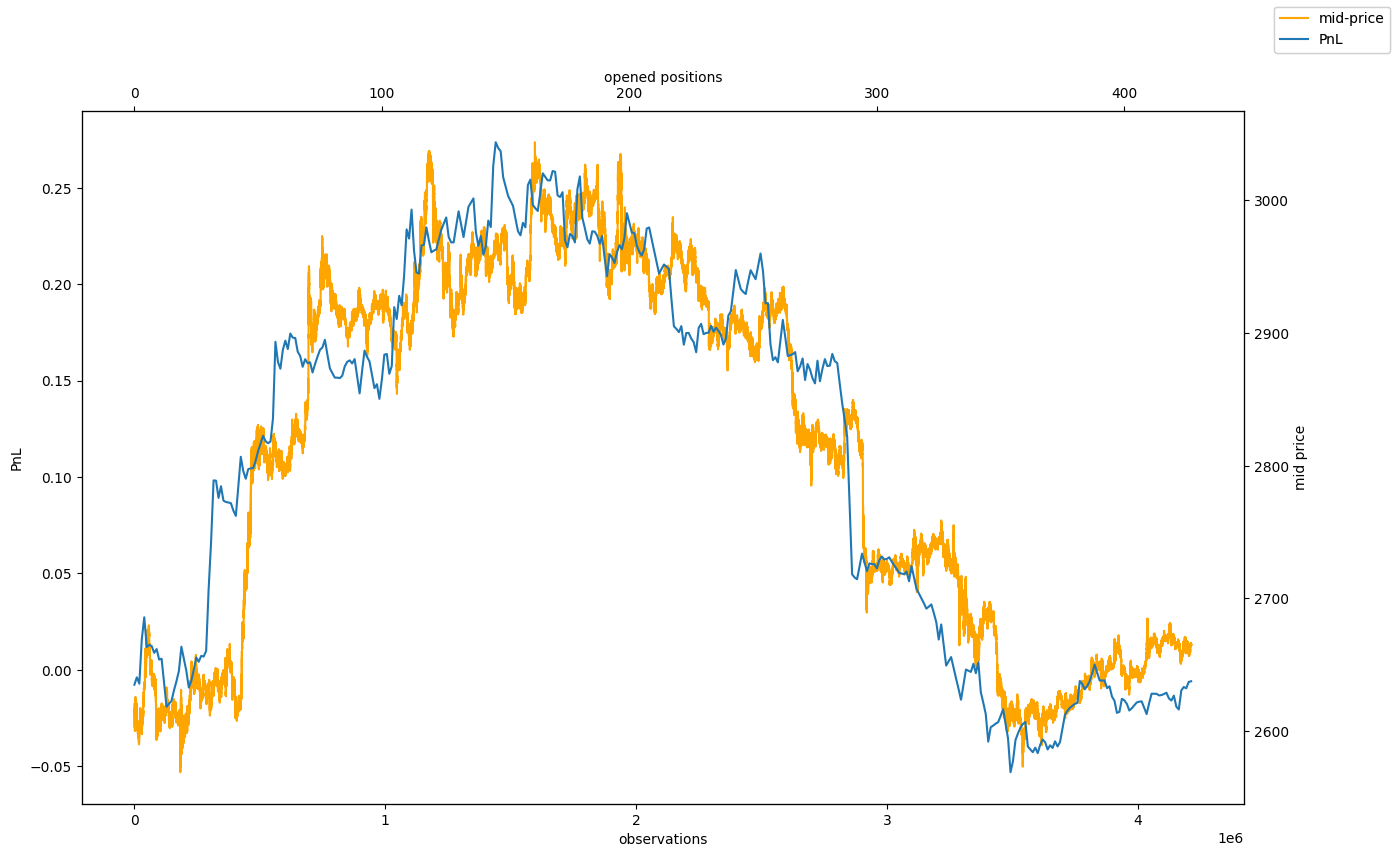

In [543]:
df = brut_to_onedf(exch,asset)
df['date'] = (df['timestamp']/10**6).apply(datetime.fromtimestamp)
df      = feature_creation(df)


fig,ax1 = plt.subplots(figsize = (15,9))
ax2 = ax1.twinx()
obs = ax1.twiny()

obs.plot(np.cumsum(final_pnl),label='PnL')
ax2.plot(df.mid,'orange',label='mid-price')

ax1.set_xlabel('observations')
ax1.set_ylabel('PnL')
ax2.set_ylabel('mid price')
obs.set_xlabel('opened positions')

# Create a shared legend for both axes
handles, labels = [], []
for ax in [ax1, ax2, obs]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
shared_legend = fig.legend(handles, labels, loc='upper right')

# Set the legend for each axis to the shared legend
ax1.add_artist(shared_legend)


plt.show()